<a href="https://colab.research.google.com/github/kslote1/Data-Driven-Dynamics/blob/main/Shred_with_Granger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Transformer Implementation
class SHREDTransformer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, num_layers=2, l1=350, l2=400, dropout=0.5, nhead=1):
        super(SHREDTransformer, self).__init__()

        # Ensure input size matches hidden size for Transformer Encoder
        self.embedding = nn.Linear(input_size, hidden_size)  # Project input to hidden_size

        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,  # Dimension must match hidden size
            nhead=nhead,  # Number of attention heads
            dim_feedforward=hidden_size * 4,  # Typical FFN size (4x hidden)
            dropout=dropout,
            batch_first=True  # Ensures input shape (batch, seq, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project input into embedding space
        x = self.embedding(x)

        # Pass through Transformer Encoder
        x = self.transformer_encoder(x)

        # Take the mean of the sequence (Global Pooling)
        x = x.mean(dim=1)

        # Feedforward layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        return self.fc3(x)


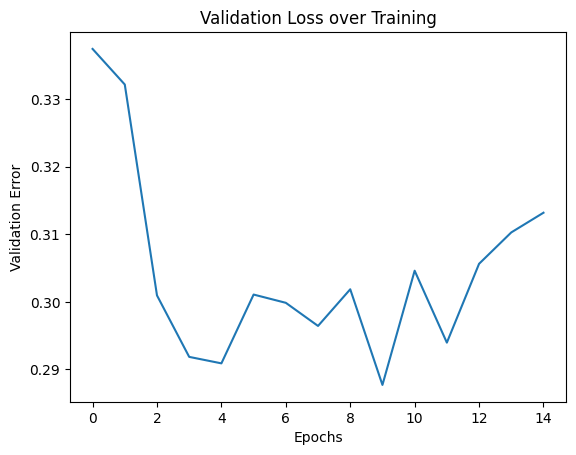

Model saved to shred_model.pth


In [3]:
import numpy as np
import scipy.linalg
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.len

def qr_place(data_matrix, num_sensors):
    u, s, v = np.linalg.svd(data_matrix, full_matrices=False)
    rankapprox = u[:, :num_sensors]
    q, r, pivot = scipy.linalg.qr(rankapprox.T, pivoting=True)
    return pivot[:num_sensors], rankapprox


class SHRED(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1):
        super(SHRED, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                  num_layers=hidden_layers, batch_first=True)
        self.linear1 = torch.nn.Linear(hidden_size, l1)
        self.linear2 = torch.nn.Linear(l1, l2)
        self.linear3 = torch.nn.Linear(l2, output_size)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        h_0 = torch.zeros((2, x.size(0), 64), dtype=torch.float).to(device)
        c_0 = torch.zeros((2, x.size(0), 64), dtype=torch.float).to(device)
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out[-1].view(-1, 64)
        output = torch.relu(self.linear1(h_out))
        output = torch.relu(self.linear2(self.dropout(output)))
        return self.linear3(self.dropout(output))


def fit(model, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, patience=5):
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    val_error_list = []
    best_params = model.state_dict()
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        for data in train_loader:
            model.train()
            optimizer.zero_grad()
            loss = criterion(model(data[0]), data[1])
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            model.eval()
            val_error = torch.linalg.norm(model(valid_dataset.X) - valid_dataset.Y) / torch.linalg.norm(valid_dataset.Y)
            val_error_list.append(val_error.item())

        if val_error == min(val_error_list):
            best_params = deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter == patience:
            model.load_state_dict(best_params)
            break

    return val_error_list

data_path = "/content/drive/MyDrive/data/E3Data.mat"
e3data = sio.loadmat(data_path)
X = e3data['X1']
df = pd.DataFrame(X,
    columns=[f"{column_index}" for column_index in range(120)]
)

num_sensors = 60
lags = 100

n, m = X.shape
train_indices = np.arange(0, int(n*0.85))
valid_indices = np.arange(int(n*0.85), n - lags)

sensor_locations, U_r = qr_place(X[train_indices].T, num_sensors)
sc = MinMaxScaler().fit(X)#[train_indices])
transformed_X = sc.transform(X)

all_data_in = np.array([transformed_X[i:i+lags, sensor_locations] for i in range(n - lags)])

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)

train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)

# Train Model
shred_model = SHRED(num_sensors, m).to(device)
val_errors = fit(shred_model, train_dataset, valid_dataset)

# Plot Validation Loss
plt.plot(val_errors)
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.title('Validation Loss over Training')
plt.show()

# Save Model
model_path = 'shred_model.pth'
torch.save(shred_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [5]:
torch.cuda.empty_cache()

<Axes: >

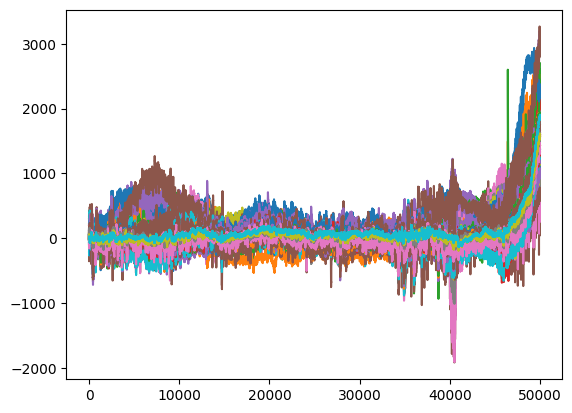

In [4]:
df.plot(legend=False)

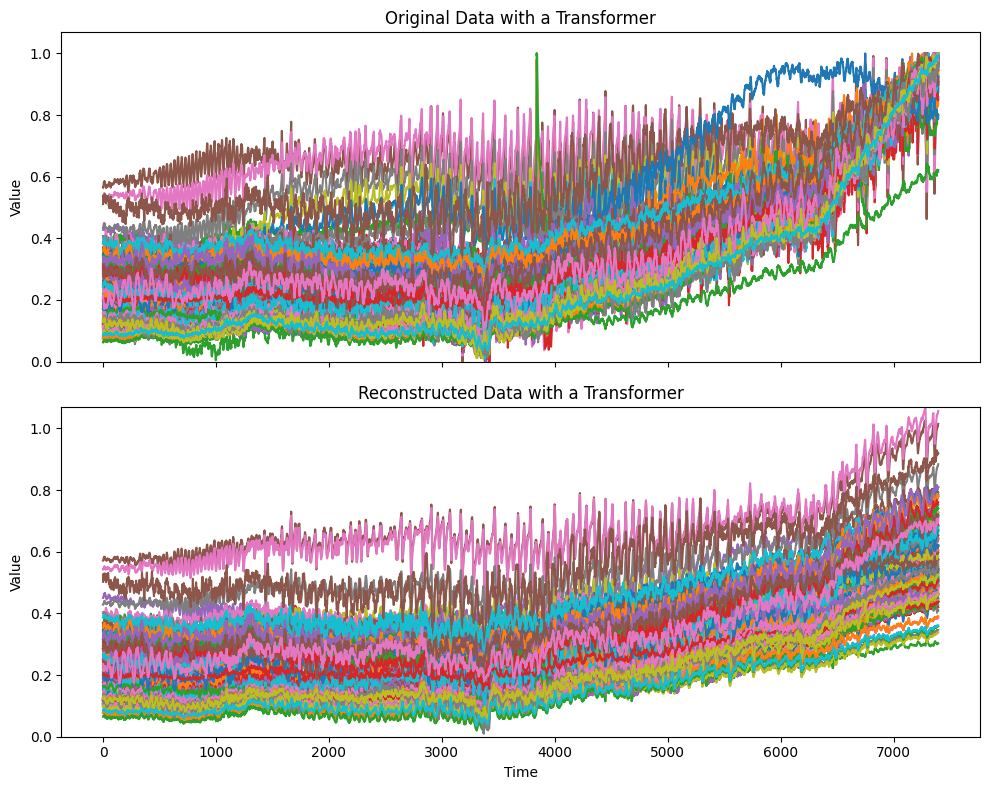

In [4]:
import matplotlib.pyplot as plt


# Convert tensors to numpy arrays
original_data = valid_data_out.cpu().numpy()
reconstructed_data = shred_model(valid_data_in).detach().cpu().numpy()


# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot original data
axes[0].plot(original_data, linestyle='solid', label='Original')
axes[0].set_ylabel('Value')
axes[0].set_title('Original Data with a Transformer')
#axes[0].legend()

# Plot reconstructed data
axes[1].plot(reconstructed_data, label='Reconstructed')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].set_title('Reconstructed Data with a Transformer')
#axes[1].legend()

axes[0].set_ylim([min(original_data.min(), reconstructed_data.min()), max(original_data.max(), reconstructed_data.max())])
axes[1].set_ylim(axes[0].get_ylim())  # Ensure both have the same limits

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [5]:
reconstructed_data.shape

(7396, 120)

In [6]:
np.save('reconstructed_data.npy', reconstructed_data)

In [7]:
from joblib import Parallel, delayed, parallel_backend
import numpy as np
import networkx as nx


def threshold(mat):
    r"""Threshold by setting values not within a list of ranges to zero.

    Parameters
    ----------
    mat (np.ndarray)
        A numpy array that is the adjaceny matrix.

    Returns
    -------
    thresholded_mat (np.ndarray)
        the thresholded numpy array

    """
    thresholded_mat = mat

    crit = np.percentile(thresholded_mat.flatten(), [0, 95])[1]
    thresholded_mat[thresholded_mat < crit] = 0
    thresholded_mat[thresholded_mat >= crit] = 1
    return thresholded_mat


def create_graph(A, remove_self_loops=True):
    """Flexibly creating a networkx graph from a numpy array.

    Parameters
    ----------
    A (np.ndarray)
        A numpy array that is the adjacecny matrix of the graph to threshold.

    remove_self_loops (bool)
        If True, remove the diagonal of the matrix before creating the
        graph object.

    Returns
    -------
    G
        A graph, typically a nx.Graph or nx.DiGraph.

    """
    if np.allclose(A, A.T):
        raise Exception("Network adjacency is not a digraph.")
    if remove_self_loops:
        np.fill_diagonal(A, 0)
    G = nx.from_numpy_array(A, create_using=nx.DiGraph())
    return G


class GrangerCausality():
    """Uses the Granger causality between nodes."""

    def __init__(self):
        self.results = {}

    def fit(self, TS, lag=1):
        r"""
        Reconstruct a network based on the Granger causality.

        Parameters
        ----------
        TS (np.ndarray): Time series data with shape (N, L).
        lag (int): Time lag to consider.

        Returns
        --------
        G (nx.Graph): A reconstructed graph with N nodes.
        W (np.array): W matrix wis magnitude of the Granger Causation
        """

        n, T = TS.shape
        input_size = T - lag - 1

        # Precompute xi and yi for all nodes
        xi_list = np.zeros((n, input_size, lag))
        yi_list = np.zeros((n, input_size))
        for i in range(n):
            xi, yi = self.split_data(TS[i, :], lag)
            xi_list[i] = xi
            yi_list[i] = yi

        # Function to compute W[:, i] in parallel
        def compute_W_column(i):
            xi = xi_list[i]
            yi = yi_list[i]

            # Fit regression model for node i
            beta_i = np.linalg.lstsq(xi, yi, rcond=None)[0]
            err1 = yi - xi @ beta_i
            var1 = np.var(err1, ddof=1)

            W_i = np.zeros(n)
            for j in range(n):
                xj = xi_list[j]
                xij = np.hstack((xi, xj))

                # Fit regression model with xi and xj
                beta_ij = np.linalg.lstsq(xij, yi, rcond=None)[0]
                err2 = yi - xij @ beta_ij
                var2 = np.var(err2, ddof=1)

                # Compute Granger causality measure
                if var1 == 0:
                    W_i[j] = -np.inf
                elif var2 == 0:
                    W_i[j] = np.inf
                else:
                    W_i[j] = np.log(var1) - np.log(var2)
            return W_i

        # Compute W matrix in parallel
        W_list = Parallel(n_jobs=-1)(
            delayed(compute_W_column)(i) for i in range(n)
        )
        # with parallel_backend('loky', n_jobs=-1):
        #     W_list = Parallel()(delayed(compute_W_column)(i) for i in range(n))

        W = np.column_stack(W_list)
        #print(W_list)

        self.results["weights_matrix"] = W
        # Threshold the network
        W_thresh = threshold(W)
        self.results["thresholded_matrix"] = W_thresh
        G = create_graph(W_thresh)

        return G, np.column_stack(W_list)

    @staticmethod
    def split_data(TS, lag):
        """Prepare inputs and targets for regression.

        Parameters
        ----------
        TS (np.ndarray): Time series data for one node.
        lag (int): Time lag to consider.

        Returns
        -------
        inputs (np.ndarray): Input data for regression.
        targets (np.ndarray): Target data for regression.
        """
        T = len(TS)
        inputs = np.array([TS[t:t + lag] for t in range(T - lag - 1)])
        targets = TS[lag + 1:]
        return inputs, targets

In [10]:
GC = GrangerCausality()
G, W = GC.fit(reconstructed_data.T, lag=10)

In [20]:
import numpy as np

# Assuming reconstructed_data is already defined
num_windows = 12
window_size = reconstructed_data.shape[1] // num_windows  # Divide along the sample axis

# Lists to store results
G_list = []
W_list = []

GC = GrangerCausality()

for i in range(num_windows):
    start_idx = i * window_size
    end_idx = start_idx + window_size
    window_data = reconstructed_data.T[:, start_idx:end_idx]  # Splice the data
    print(window_data.shape)

    G, W = GC.fit(window_data, lag=5)
    G_list.append(G)
    W_list.append(W)

(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)


In [38]:
in_degree = np.zeros((12, 120))
out_degree = np.zeros((12, 120))
dif_degree = np.zeros((12, 120))
node_degree = np.zeros((12, 120))
for i, G in enumerate(G_list):

    # A = nx.adjacency_matrix(G)
    # A = A.todense()
    # As.append(A)
    # crit = np.percentile(np.array(A).flatten(), [5, 85])[0] #np.percentile(A, [2.75, 85])[1]
    # A[A < crit] = 0
    # A[A >= crit] = 1
    # G = nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for j, node in enumerate(G.nodes):
        in_degree[i,j] = G.in_degree(node)
        out_degree[i,j] = G.out_degree(node)
        dif_degree[i,j] = G.out_degree(node) - G.in_degree(node)
        node_degree[i,j] = G.degree(node)

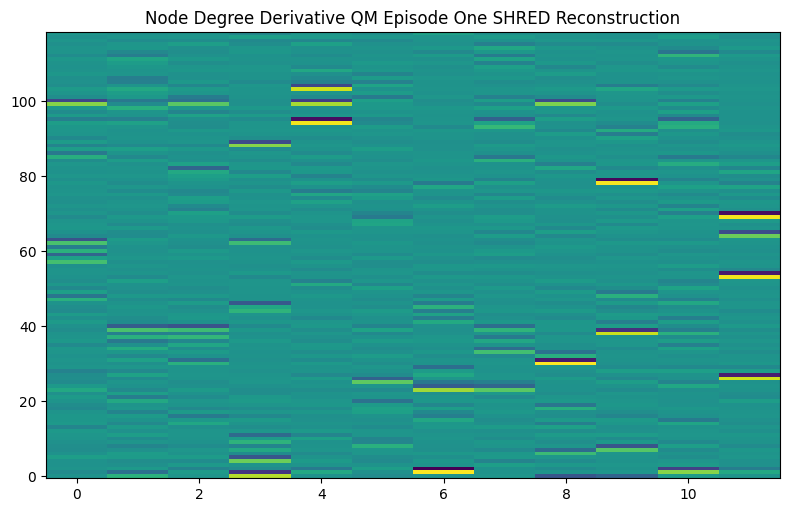

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.imshow(np.diff(node_degree.T, axis=0), origin='lower', cmap='viridis', aspect='auto')
plt.tight_layout()
plt.title("Node Degree Derivative QM Episode One SHRED Reconstruction")
plt.show()